## Parameters

In [4]:
MODEL = 'cnn' # mlp or cnn
DATA = 'noniid' # iid or noniid
N_CLIENTS = 100
C = 0.1
E = 1
B = 10 # 'all' for a single minibatch

c_rounds = 200

lrs = [0.1] # learning rate

target_test_acc = 0.99

## Mount to Google Drive (Optional)

If the training & testing result want to be saved to Google Drive

In [5]:
# from google.colab import drive
# drive.flush_and_unmount()
# drive.mount('/content/drive/', force_remount=True)

In [6]:
# dir = '/content/drive/MyDrive/federated-learning/' # make sure this is pointing to a correct directory in the Google Drive

In [7]:
dir=''

## Import Modules

In [8]:
import logging
import math
import os
import pickle
import random
import re
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from datetime import timedelta
from keras import backend as K
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tqdm import tqdm
tf.get_logger().setLevel(logging.ERROR)

In [9]:
tf.test.gpu_device_name()

''

In [10]:
client_ids = [i for i in range(N_CLIENTS)]

loss='categorical_crossentropy'
metrics = ['accuracy']
cce = tf.keras.losses.CategoricalCrossentropy()

## Random seed

In [8]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

## Load MNIST Data

In [9]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()


11493376/11490434 [==============================] - 0s 0us/step


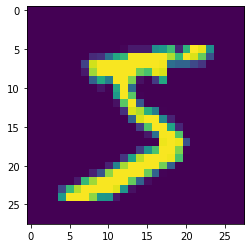

In [10]:
plt.imshow(X_train[0])

## Data Preparation

### IID or NON-IID

In [11]:
def iid_partition(y_train):
  """
    the data is shuffled, and then partitioned into 100 clients each receiving 600 examples
  """
  n_per_client = int(len(y_train)/N_CLIENTS)
  indexes_per_client = {}
  indexes = np.arange(0, len(y_train))
  random.shuffle(indexes)
  for i in range(N_CLIENTS):
    start_idx = i*n_per_client
    indexes_per_client[i] = indexes[start_idx:start_idx+n_per_client]
  return indexes_per_client


In [12]:
def noniid_partition(y_train):
  """
    sort the data by digit label, divide it into 200 shards of size 300, and assign each of 100 clients 2 shards.
  """
  n_shards = 200
  n_per_shard = 300

  indexes_per_client = {}
  indexes = y_train.argsort()

  indexes_shard = np.arange(0, n_shards)
  random.shuffle(indexes_shard)

  for i in range(N_CLIENTS):
    start_idx_shard_1 = indexes_shard[i*2]*n_per_shard
    start_idx_shard_2 = indexes_shard[i*2+1]*n_per_shard
    indexes_per_client[i] = np.concatenate((indexes[start_idx_shard_1:start_idx_shard_1+n_per_shard],
                                            indexes[start_idx_shard_2:start_idx_shard_2+n_per_shard]))
    
  return indexes_per_client


  

In [13]:
indexes_per_client = None
if DATA=='iid':
  indexes_per_client = iid_partition(y_train)
elif DATA=='noniid':
  indexes_per_client = noniid_partition(y_train)
else:
  print('DATA {} is not defined'.format(DATA))

### Normalize, Expand Dims, and Transform Labels

In [14]:
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print("x_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### Create Batched Dataset

In [15]:

def create_batch(indexes_client, X_train, y_train, B):
    x = []
    y = []    
    for i in indexes_client:
      x.append(X_train[i])
      y.append(y_train[i])

    dataset = tf.data.Dataset.from_tensor_slices((list(x), list(y)))
    return dataset.shuffle(len(y)).batch(len(y_train) if B=='all' else B)

In [16]:
client_dataset_batched = {}
for i, indexes in tqdm(indexes_per_client.items()):
  client_dataset_batched[i] = create_batch(indexes, X_train, y_train, B)

train_batched = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(len(y_train)) # for testing on train set
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


## MLP (2NN)

A simple multilayer-perceptron with 2-hidden layers with 200 units each using ReLu activations (199,210 total parameters), which is referred as the MNIST 2NN

In [17]:
class MLP:
    @staticmethod
    def build(input_shape):
        model = Sequential()
        model.add(Flatten(input_shape=input_shape))
        model.add(Dense(200, activation="relu"))
        model.add(Dense(200,  activation="relu"))
        model.add(Dense(10,  activation="softmax"))
        return model

## CNN

A CNN with two 5x5 convolution layers (the first with 32 channels, the second with 64, each followed with 2x2 max pooling), a fully connected layer with 512 units and ReLu activation, and a final softmax output layer (1,663,370 total parameters)

In [18]:
class CNN:
    @staticmethod
    def build(input_shape):
        model = Sequential()
        model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=input_shape))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(filters=64, padding='same', kernel_size=(5,5), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dense(10, activation='softmax'))
        return model

## Initialize Model

In [19]:
#initialize global model
model = None
if MODEL=='mlp':
  model = MLP()
elif MODEL=='cnn':
  model = CNN()
else:
  print('model {} is not defined'.format(MODEL))
  
global_model = model.build((28,28,1))
initial_weights = global_model.get_weights()

# client_models = [model.build((28,28,1)) for _ in range(K)]

# for i in range(len(client_models)):
#   client_models[i].compile(loss=loss, 
#                       optimizer=optimizer, 
#                       metrics=metrics)
#   client_models[i].set_weights(global_model.get_weights())

global_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1606144   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5

## Training

In [20]:
result_per_lr = {}
start = time.time()
for lr in lrs:
  train_losses = []
  train_accs = []
  test_losses = []
  test_accs = []
  optimizer = SGD(lr=lr) 
  global_model.set_weights(initial_weights)
  print('\nlearning rate: {}'.format(lr))
  for r in range(c_rounds):
    train_loss = 0
    train_acc = 0
    test_loss = 0
    test_acc = 0

    global_weights = global_model.get_weights()

    #sampling client
    m = max(int(C*N_CLIENTS), 1)
    selected_clients = random.sample(client_ids, m)

    client_models = {} # to prevent crashed due to not enough RAM 

    # client update
    for i in selected_clients:
      client_models[i] = model.build((28,28,1))
      client_models[i].compile(loss=loss, 
                        optimizer=optimizer, 
                        metrics=metrics)
      
      client_models[i].set_weights(global_weights)
      client_models[i].fit(client_dataset_batched[i], epochs=E, verbose=0)

    # averaging
    avg_weights = list()
    for j in range(len(global_weights)):
        weights = [client_models[k].get_weights()[j] for k in selected_clients]
        layer_mean = tf.math.reduce_mean(weights, axis=0)
        avg_weights.append(layer_mean)
    global_model.set_weights(avg_weights)

    # test global model on full training set
    for (X,y) in train_batched:
      preds = global_model.predict(X)
      train_loss = cce(y, preds)
      train_acc = accuracy_score(tf.argmax(preds, axis=1), tf.argmax(y, axis=1))
      train_losses.append(train_loss.numpy())
      train_accs.append(train_acc)

    # test global model on testing set
    for(X, y) in test_batched:
      preds = global_model.predict(X)
      test_loss = cce(y, preds)
      test_acc = accuracy_score(tf.argmax(preds, axis=1), tf.argmax(y, axis=1))
      test_losses.append(test_loss.numpy())
      test_accs.append(test_acc)

    elapsed = (time.time() - start)
    
    print('comm_round: {}/{} | test_acc: {:.3%} | test_loss: {} | train_acc: {:.3%} | train_loss: {} | elapsed: {}'.format(r+1, c_rounds, test_acc, test_loss, train_acc, train_loss, timedelta(seconds=elapsed)))

  result_per_lr[lr] = {
                        'train_accs' : train_accs,
                        'test_accs' : test_accs,
                        'train_losses' : train_losses,
                        'test_losses' : test_losses
                      }
  with open(dir+'result_per_lr_{}_{}_{}_{}_{}_{}.pickle'.format(B,C,E,MODEL,DATA, lr), 'wb') as handle:
    pickle.dump(result_per_lr, handle, protocol=pickle.HIGHEST_PROTOCOL)




learning rate: 0.1
comm_round: 1/200 | test_acc: 22.960% | test_loss: 2.1319215297698975 | train_acc: 22.553% | train_loss: 2.136284351348877 | elapsed: 0:00:16.107246
comm_round: 2/200 | test_acc: 30.940% | test_loss: 2.168268918991089 | train_acc: 30.800% | train_loss: 2.1657662391662598 | elapsed: 0:00:25.056726
comm_round: 3/200 | test_acc: 60.350% | test_loss: 1.4813097715377808 | train_acc: 60.217% | train_loss: 1.4934920072555542 | elapsed: 0:00:34.081560
comm_round: 4/200 | test_acc: 62.350% | test_loss: 1.2563430070877075 | train_acc: 62.220% | train_loss: 1.2630257606506348 | elapsed: 0:00:43.404940
comm_round: 5/200 | test_acc: 58.170% | test_loss: 1.0704134702682495 | train_acc: 57.800% | train_loss: 1.0795096158981323 | elapsed: 0:00:52.534228
comm_round: 6/200 | test_acc: 69.870% | test_loss: 0.908623218536377 | train_acc: 69.502% | train_loss: 0.9209845066070557 | elapsed: 0:01:01.987773
comm_round: 7/200 | test_acc: 79.510% | test_loss: 0.7426711320877075 | train_acc: 

In [21]:
with open(dir+'result_per_lr_{}_{}_{}_{}_{}.pickle'.format(B,C,E,MODEL,DATA), 'wb') as handle:
    pickle.dump(result_per_lr, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
# drive.flush_and_unmount()
# drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# with open(dir+'result_per_lr_all_0_1_mlp_iid.pickle', 'rb') as handle:
#     result_per_lr = pickle.load(handle)

## Generate Plots

In [ ]:
# target_test_acc = 0.99

In [22]:
def get_plotted_metrics(result_per_lr, comm_rounds=None):
  plotted_train_accs= []
  plotted_test_accs = []
  plotted_train_losses = []
  plotted_test_losses = []
  if comm_rounds:
    c_rounds = comm_rounds
  for c in range(c_rounds):
    best_train_acc = 0
    best_test_acc = 0
    best_train_loss = math.inf
    best_test_loss = math.inf
    for lr in result_per_lr.keys():
      best_train_acc = max(best_train_acc, result_per_lr[lr]['train_accs'][c])
      best_test_acc = max(best_test_acc, result_per_lr[lr]['test_accs'][c])
      best_train_loss = min(best_train_loss, result_per_lr[lr]['train_losses'][c])
      best_test_loss = min(best_test_loss, result_per_lr[lr]['test_losses'][c])

    if c == 0:
      plotted_train_accs.append(best_train_acc)
      plotted_test_accs.append(best_test_acc)
      plotted_train_losses.append(best_train_loss)
      plotted_test_losses.append(best_test_loss)
    else:
      if plotted_train_accs[-1] > best_train_acc:
        plotted_train_accs.append(plotted_train_accs[-1])
      else:
        plotted_train_accs.append(best_train_acc)

      if plotted_test_accs[-1] > best_test_acc:
        plotted_test_accs.append(plotted_test_accs[-1])
      else:
        plotted_test_accs.append(best_test_acc)

      if plotted_train_losses[-1] < best_train_loss:
        plotted_train_losses.append(plotted_train_losses[-1])
      else:
        plotted_train_losses.append(best_train_loss)

      if plotted_test_losses[-1] < best_test_loss:
        plotted_test_losses.append(plotted_test_losses[-1])
      else:
        plotted_test_losses.append(best_test_loss)

  return plotted_train_accs, plotted_test_accs, plotted_train_losses, plotted_test_losses



In [24]:
plotted_train_accs, plotted_test_accs, plotted_train_losses, plotted_test_losses = get_plotted_metrics(result_per_lr)

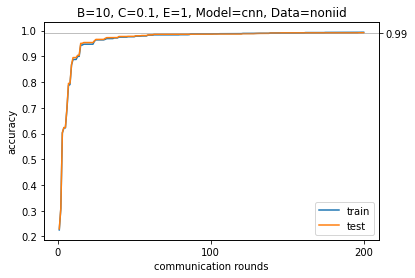

In [25]:
fig, ax = plt.subplots()
ax.plot(range(1, len(plotted_train_accs)+1), plotted_train_accs, label='train')
ax.plot(range(1,len(plotted_test_accs)+1), plotted_test_accs, label='test')
ax.set_xticks(np.arange(0, len(plotted_test_accs)+1, 100))
ax.axhline(y=target_test_acc, color='grey', linestyle='-', linewidth=0.5)
ax.set_ylabel('accuracy')

ax.set_xlabel('communication rounds')
ax.set_title('B={}, C={}, E={}, Model={}, Data={}'.format(B, C, E, MODEL, DATA))
ax.legend()

ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks([target_test_acc])

plt.show()

# plt.savefig('./save/fed_{}_{}_{}_C{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.frac, args.iid))

In [26]:
n_round_at_target = None
for i,acc in enumerate(plotted_test_accs):
  if acc>=target_test_acc:
    print("the number of rounds to achieve target test-accuracy: ")
    n_round_at_target = i+1
    print(n_round_at_target)
    break;


the number of rounds to achieve target test-accuracy: 
139


In [27]:
loss_at_target = None
for i,loss in 
(plotted_test_losses):
  if n_round_at_target and i==n_round_at_target-1:
    print("loss at target test-accuracy: ")
    loss_at_target = loss
    print(loss_at_target)
    break;


loss at target test-accuracy: 
0.030209027


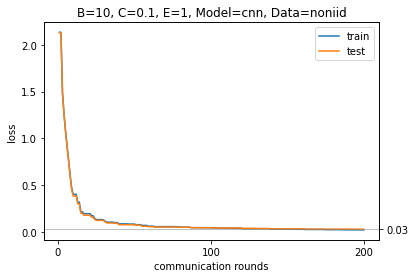

In [28]:
fig, ax = plt.subplots()
ax.plot(range(1, len(plotted_train_losses)+1), plotted_train_losses, label='train')
ax.plot(range(1,len(plotted_test_losses)+1), plotted_test_losses, label='test')
ax.set_xticks(np.arange(0, len(plotted_test_losses)+1, 100))
if loss_at_target is not None:
  ax.axhline(loss_at_target, color='grey', linestyle='-', linewidth=0.5)
ax.set_ylabel('loss')
ax.set_xlabel('communication rounds')
ax.set_title('B={}, C={}, E={}, Model={}, Data={}'.format(B, C, E, MODEL, DATA))
ax.legend()

ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
if loss_at_target is not None:
  ax2.set_yticks([loss_at_target])

plt.show()

# plt.savefig('./save/fed_{}_{}_{}_C{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.frac, args.iid))

## Generate Multi Cases Plots

Here, we first need to copy manually all of the training result files that we want to be included in the generated plot. So that the `os.listdir()` can detect the files.

In [127]:
result_files = os.listdir()
result_files = [file for file in result_files if 'result' and '_iid' in file]
result_files.sort()

In [128]:
result_files

['result_per_lr_10_0.1_1_cnn_noniid.pickle',
 'result_per_lr_10_0.1_20_cnn_noniid.pickle',
 'result_per_lr_50_0.1_1_cnn_noniid.pickle',
 'result_per_lr_50_0.1_20_cnn_noniid.pickle',
 'result_per_lr_all_0.1_1_cnn_noniid.pickle',
 'result_per_lr_all_0.1_20_cnn_noniid.pickle']

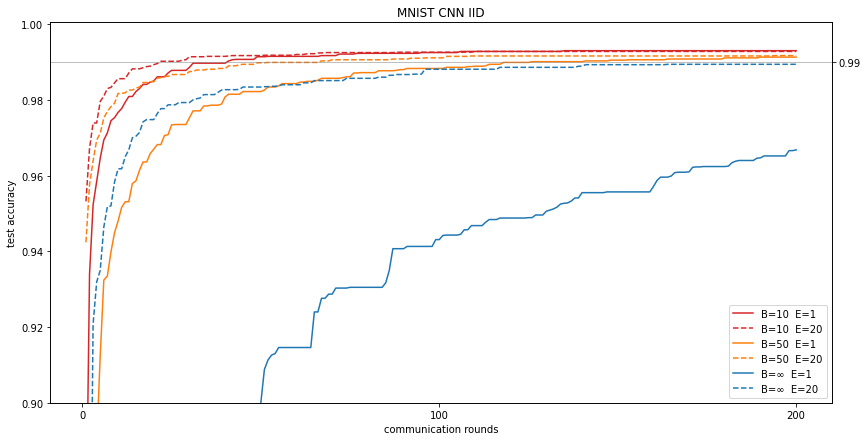

In [126]:
colors = ['tab:red', 'tab:orange', 'tab:blue']
fig, ax = plt.subplots(figsize=(14,7))
for i,file in enumerate(result_files):
  with open(file, 'rb') as handle:
    result_per_lr = pickle.load(handle)
  plotted_train_accs, plotted_test_accs, plotted_train_losses, plotted_test_losses = get_plotted_metrics(result_per_lr, 200)

  batch = re.search('(?<=result_per_lr_)(.*?)(?=_)', file).groups()[0]
  epoch = re.search('(?:.*?_){5}(.*?)(?=_)', file).groups()[0]
  batch = '∞' if batch=='all' else batch

  color = colors[int(i/2)%3]
  linestyle = '-' if i%2==0 else '--'
  ax.plot(range(1, len(plotted_test_accs)+1), plotted_test_accs, label='B={}  E={}'.format(batch, epoch), color=color, linestyle=linestyle)
ax.set_xticks(np.arange(0, len(plotted_test_accs)+1, 100))
ax.axhline(y=0.99, color='grey', linestyle='-', linewidth=0.5)
ax.set_ylabel('test accuracy')

ax.set_xlabel('communication rounds')
ax.set_title('MNIST CNN IID')
ax.legend()

ax.set_ylim((0.9, 1.0005))

ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks([0.99])

plt.show()

# plt.savefig('./save/fed_{}_{}_{}_C{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.frac, args.iid))

In [ ]:
result_files = os.listdir()
result_files = [file for file in result_files if 'result' and 'noniid' in file]
result_files.sort()

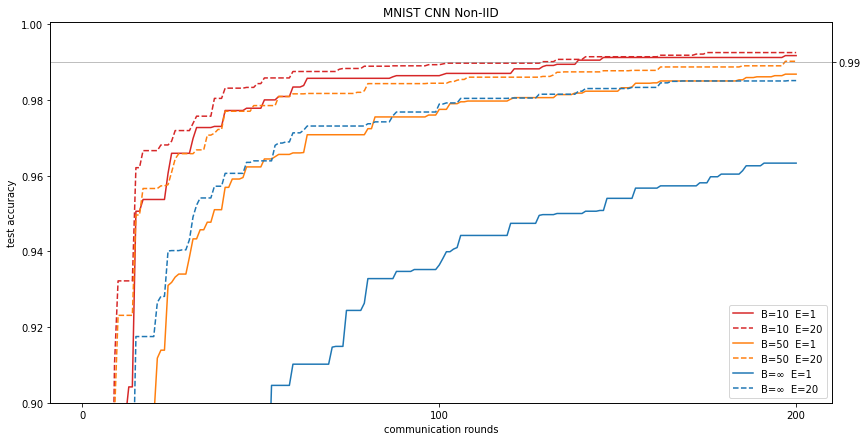

In [129]:
colors = ['tab:red', 'tab:orange', 'tab:blue']
fig, ax = plt.subplots(figsize=(14,7))
for i,file in enumerate(result_files):
  with open(file, 'rb') as handle:
    result_per_lr = pickle.load(handle)
  plotted_train_accs, plotted_test_accs, plotted_train_losses, plotted_test_losses = get_plotted_metrics(result_per_lr, 200)

  batch = re.search('(?<=result_per_lr_)(.*?)(?=_)', file).groups()[0]
  epoch = re.search('(?:.*?_){5}(.*?)(?=_)', file).groups()[0]
  batch = '∞' if batch=='all' else batch

  color = colors[int(i/2)%3]
  linestyle = '-' if i%2==0 else '--'
  ax.plot(range(1, len(plotted_test_accs)+1), plotted_test_accs, label='B={}  E={}'.format(batch, epoch), color=color, linestyle=linestyle)
ax.set_xticks(np.arange(0, len(plotted_test_accs)+1, 100))
ax.axhline(y=0.99, color='grey', linestyle='-', linewidth=0.5)
ax.set_ylabel('test accuracy')

ax.set_xlabel('communication rounds')
ax.set_title('MNIST CNN Non-IID')
ax.legend()

ax.set_ylim((0.9, 1.0005))

ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks([0.99])

plt.show()

# plt.savefig('./save/fed_{}_{}_{}_C{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.frac, args.iid))